In [12]:
from encode import sample_files, get_units
from utils.features import DataSet
from pathlib import Path
import concurrent.futures

dataset = DataSet(
    name="librispeech-dev-clean",
    in_dir=Path("data/dev-clean"),
    align_dir=Path("data/alignments/dev-clean"),
    feat_dir=Path("features"), 
    audio_ext=".flac" 
)

sampled_paths = sample_files(dataset, -1)
print(len(sampled_paths))

2703


In [3]:
from distance import load_units

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_hubert = executor.submit(load_units, dataset, sampled_paths, 0.0)
    future_dusted = executor.submit(load_units, dataset, sampled_paths, 0.2)

    hubert_words = future_hubert.result()
    dusted_words = future_dusted.result()

Loading Units: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


In [13]:

hubert_words, dusted_words = get_units(dataset, sampled_paths)


Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units:   0%|          | 3/2703 [00:00<07:44,  5.82it/s]

Hubert 16: _
Dusted 17: _


Getting units:   0%|          | 6/2703 [00:01<14:17,  3.15it/s]

Hubert 66: _


Getting units:   0%|          | 8/2703 [00:02<15:01,  2.99it/s]

Dusted 67: _
Hubert 100: _


Getting units:   0%|          | 9/2703 [00:02<19:18,  2.32it/s]

Dusted 101: _


Getting units:   0%|          | 11/2703 [00:03<14:35,  3.07it/s]

Hubert 136: _
Dusted 137: _


Getting units:   1%|          | 14/2703 [00:05<23:21,  1.92it/s]

Hubert 219: _
Dusted 220: _


Getting units:   1%|          | 16/2703 [00:08<22:44,  1.97it/s]


KeyboardInterrupt: 

In [3]:
from collections import Counter

num_words = len(hubert_words)
true_words = []
print(len(dusted_words), len(hubert_words))

avg_words = []
for w in range(num_words): 
    new_word = hubert_words[w].copy()
    hubert_units = hubert_words[w].clean_encoding
    dusted_units = dusted_words[w].clean_encoding

    common_units = list(dict.fromkeys(unit for unit in hubert_units if unit in dusted_units))
    new_word.update_encoding(common_units)
    avg_words.append(new_word)

    if not isinstance(new_word.true_word, str):
        true_words.append("_")
    else:
        true_words.append(new_word.true_word)

counts = Counter(true_words)
not_ones = {}
for c in counts:
    if counts[c] > 1:
        not_ones[c] = counts[c]
print(not_ones)


224 224
{'_': 31, 'the': 16, 'to': 6, 'off': 2, 'they': 2, 'and': 8, 'so': 2, 'he': 4, 'a': 6, 'large': 2, 'one': 3, 'it': 2, 'was': 2, 'of': 3, 'which': 2, 'with': 2, 'you': 2, 'had': 2, 'in': 3, 'i': 2, 'have': 2, 'stepped': 2, 'as': 2, 'our': 3}


In [4]:
import numpy as np 
from tqdm import tqdm
import editdistance

true_words = []
dusted_true_words = []
dist_mat_hub = np.zeros((num_words, num_words))
dist_mat_dust = np.zeros((num_words, num_words))
for i in tqdm(range(num_words), desc="Calculating Distances"):
    true_words.append(hubert_words[i].true_word)
    dusted_true_words.append(dusted_words[i].true_word)
    for j in range(i+1, num_words):
        dist_mat_hub[i, j] = editdistance.eval(hubert_words[i].clean_encoding, hubert_words[j].clean_encoding)/(len(hubert_words[i].clean_encoding) + len(hubert_words[j].clean_encoding))
        dist_mat_hub[j, i] = dist_mat_hub[i, j]

        dist_mat_dust[i, j] = editdistance.eval(dusted_words[i].clean_encoding, dusted_words[j].clean_encoding)/(len(dusted_words[i].clean_encoding) + len(dusted_words[j].clean_encoding))
        dist_mat_dust[j, i] = dist_mat_dust[i, j]

print(true_words)

Calculating Distances: 100%|██████████| 224/224 [00:00<00:00, 2450.60it/s]

['_', 'not', 'at', 'the', 'hotel', '_', 'just', 'now', '_', 'preface', 'to', '_', 'second', 'edition', '_', 'the', 'leaden', 'hail', 'storm', 'swept', 'them', 'off', 'the', 'field', '_', 'they', 'fell', 'back', 'and', 're', 'formed', '_', 'so', 'he', 'got', 'a', 'large', 'two', 'inch', 'rope', 'tied', 'one', 'end', 'around', 'the', "mule's", 'neck', 'and', 'the', 'other', 'to', 'the', 'caisson', '_', 'and', 'ordered', 'the', 'driver', 'to', 'whip', 'up', '_', 'it', 'was', 'one', 'of', 'those', 'effects', 'which', 'a', 'painter', 'loves', 'to', 'represent', '_', 'and', 'mingled', 'well', 'with', 'the', 'struggling', 'light', '_', 'which', 'found', 'its', 'way', 'between', 'the', 'boughs', 'of', 'the', 'shady', '_', 'arch', '_', 'that', 'vaulted', '_', 'the', 'broad', '_', 'green', 'alley', '_', 'hansel', 'thought', 'the', 'roof', 'tasted', 'very', 'nice', '_', 'and', 'so', 'he', 'tore', 'off', 'a', 'great', 'piece', '_', 'while', 'grethel', 'broke', 'a', 'large', 'round', 'pane', '_', '

/tmp/ipykernel_8034/534416251.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_mat_dust, method='average')


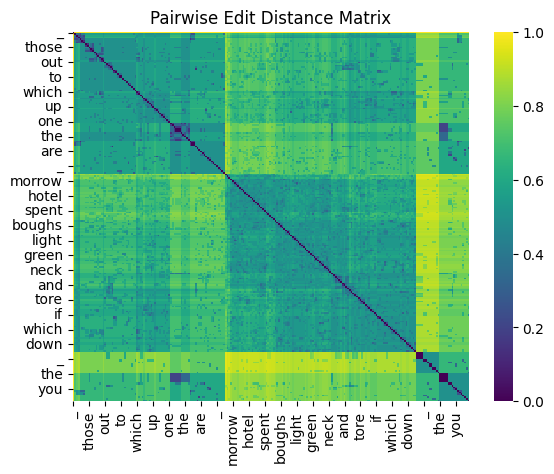

Cluster 3
3 the
99 the
44 the
206 the
79 the
51 the
88 the
153 the
186 the
132 the
107 the
56 the
91 the
22 the

Cluster 8
8 _
162 _
140 _
31 _
150 _
24 _
61 _
112 _
53 _
14 _

Cluster 26
29 re
33 he

Cluster 30
35 a
58 to

Cluster 31
36 large
126 large

Cluster 52
63 was
152 was

Cluster 54
65 of
131 of

Cluster 57
68 which
78 with
178 with

Cluster 64
75 and
177 and

Cluster 71
84 found
137 down

Cluster 78
93 _
129 _
211 _
190 _

Cluster 80
95 _
98 _

Cluster 84
101 _
172 _

Cluster 94
113 and
135 and

Cluster 96
115 he
143 you

Cluster 99
118 a
219 a
166 a

Cluster 121
148 to
173 to

Cluster 127
157 had
195 had

Cluster 130
160 his
192 as

Cluster 133
164 have
215 have

Cluster 144
180 he
203 _

Cluster 161
201 our
222 our

Cluster 165
207 first
209 from



In [7]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df_dust = pd.DataFrame(dist_mat_dust, index=true_words, columns=true_words)
linked = linkage(dist_mat_dust, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_dust.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

dust_clusters = cluster(dist_mat_dust, 0.25)

for d, d_clust in enumerate(dust_clusters):
    if len(d_clust)>1:
        print(f"Cluster {d}")
        for k in range(len(d_clust)):
            word_k = [w for w in dusted_words if w.id == d_clust[k]]
            print(word_k[0].id ,word_k[0].true_word)
        print()

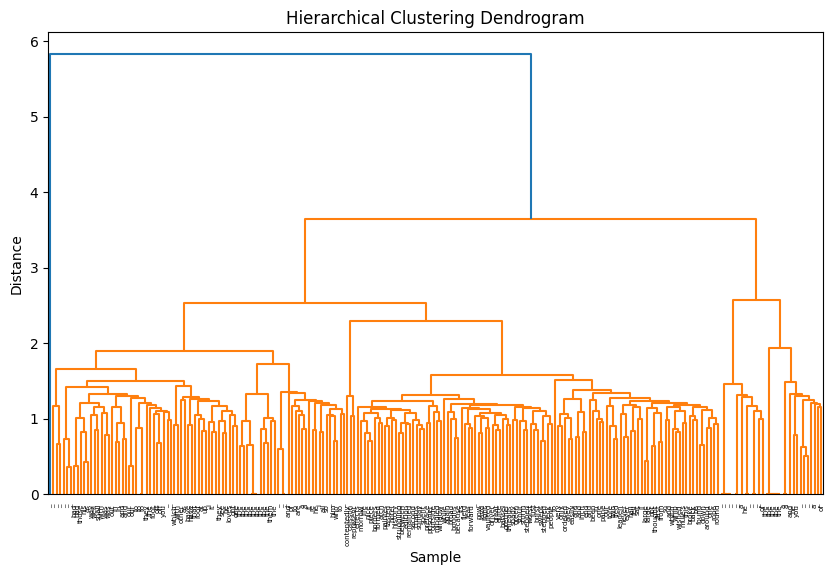

In [9]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
r = dendrogram(linked, labels=true_words)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()


/tmp/ipykernel_8034/3057113707.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(dist_df_hub, method='average')


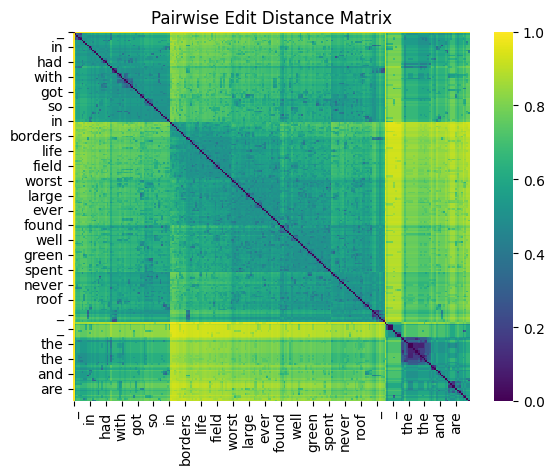

Cluster 3
the
the
the
the
the
the
the
the
the
the
the
the
the
the
the

Cluster 14
_
_
_
_

Cluster 46
to
to
to

Cluster 48
_
_
_

Cluster 57
was
was

Cluster 59
of
of
of

Cluster 63
a
a
a
a

Cluster 77
found
down

Cluster 83
_
_
_

Cluster 85
_
_

Cluster 99
and
and

Cluster 132
had
had

Cluster 145
_
_



In [10]:
from cluster import cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

dist_df_hub = pd.DataFrame(dist_mat_hub, index=true_words, columns=true_words)
linked = linkage(dist_df_hub, method='average')
order = leaves_list(linked)
reordered_dist_df = dist_df_hub.iloc[order, order]

plt.Figure(figsize=(8,6))
sns.heatmap(reordered_dist_df, cmap='viridis')
plt.title("Pairwise Edit Distance Matrix")
plt.show()

hub_clusters = cluster(dist_mat_hub, 0.2)

for h, h_clust in enumerate(hub_clusters):
    if len(h_clust)>1:
        print(f"Cluster {h}")
        for k in range(len(h_clust)):
            word_k = [w for w in dusted_words if w.id == h_clust[k]]
            print(word_k[0].true_word)
        print()

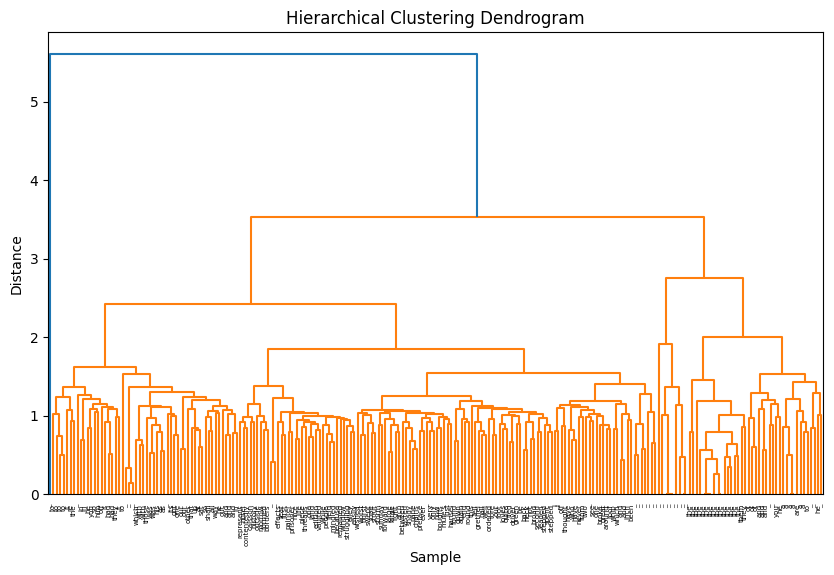

In [11]:
from scipy.cluster.hierarchy import dendrogram

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=true_words)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample')
plt.ylabel('Distance')
plt.show()